#EN3150 Assignment 03: Simple convolutional neural network to perform classification.


## 1 CNN for image classification

Data loading

In [9]:
import os
import zipfile

dataset_url = "https://archive.ics.uci.edu/static/public/908/realwaste.zip"

!wget -O realwaste.zip {dataset_url}

if not os.path.exists("realwaste"):
    os.makedirs("realwaste")

with zipfile.ZipFile("realwaste.zip", "r") as zip_ref:
    zip_ref.extractall("realwaste")

print("Dataset downloaded and extracted successfully!")

dataset_path = "realwaste"
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        print(os.path.join(root, file))


--2024-12-12 14:06:16--  https://archive.ics.uci.edu/static/public/908/realwaste.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘realwaste.zip’

realwaste.zip           [  <=>               ] 656.65M  89.8MB/s    in 7.9s    

2024-12-12 14:06:24 (83.3 MB/s) - ‘realwaste.zip’ saved [688545323]

Dataset downloaded and extracted successfully!
realwaste/realwaste-main/README.md
realwaste/realwaste-main/RealWaste/Miscellaneous Trash/Miscellaneous Trash_125.jpg
realwaste/realwaste-main/RealWaste/Miscellaneous Trash/Miscellaneous Trash_270.jpg
realwaste/realwaste-main/RealWaste/Miscellaneous Trash/Miscellaneous Trash_84.jpg
realwaste/realwaste-main/RealWaste/Miscellaneous Trash/Miscellaneous Trash_206.jpg
realwaste/realwaste-main/RealWaste/Miscellaneous Trash/Miscellaneous Trash_448.jpg
realwaste/real

In [10]:
import os
import random

dataset_path = r"/content/realwaste/realwaste-main/RealWaste"

# Define classes
classes = ["Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash", "Paper", "Plastic", "Textile Trash", "Vegetation"]
class_paths = {cls: os.path.join(dataset_path, cls) for cls in classes}
class_paths

{'Cardboard': '/content/realwaste/realwaste-main/RealWaste/Cardboard',
 'Food Organics': '/content/realwaste/realwaste-main/RealWaste/Food Organics',
 'Glass': '/content/realwaste/realwaste-main/RealWaste/Glass',
 'Metal': '/content/realwaste/realwaste-main/RealWaste/Metal',
 'Miscellaneous Trash': '/content/realwaste/realwaste-main/RealWaste/Miscellaneous Trash',
 'Paper': '/content/realwaste/realwaste-main/RealWaste/Paper',
 'Plastic': '/content/realwaste/realwaste-main/RealWaste/Plastic',
 'Textile Trash': '/content/realwaste/realwaste-main/RealWaste/Textile Trash',
 'Vegetation': '/content/realwaste/realwaste-main/RealWaste/Vegetation'}

In [11]:
import pandas as pd

def count_files(folder_path):
    file_list = os.listdir(folder_path)
    return len(file_list)

classes_dict = {cls: count_files(class_paths[cls]) for cls in classes}

classes_df = pd.DataFrame.from_dict(classes_dict, orient='index', columns=['Number of Images'])

classes_df

,Number of Images
Cardboard,461
Food Organics,411
Glass,420
Metal,790
Miscellaneous Trash,495
Paper,500
Plastic,921
Textile Trash,318
Vegetation,436


<Figure size 1000x600 with 0 Axes>

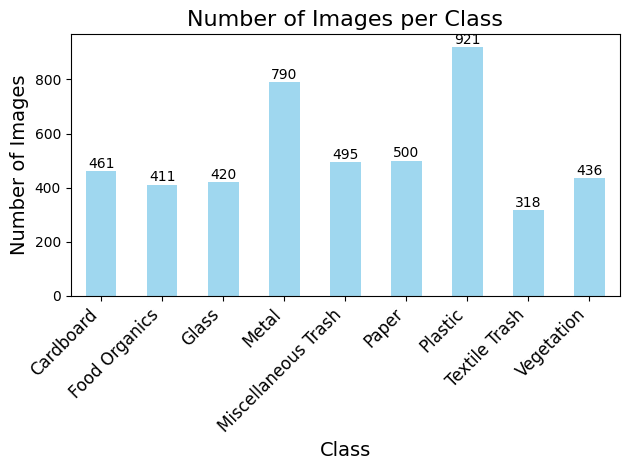

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax= classes_df.plot(
    kind='bar',
    legend=False,
    color='skyblue',
    alpha=0.8
)

plt.title("Number of Images per Class", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
for i, value in enumerate(classes_df['Number of Images']):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [13]:
#create the data frame

path_list = [class_paths[cls] for cls in classes]
image_path = []
class_labels = []
for i, dir_path in enumerate(path_list):
    image_names = os.listdir(dir_path)
    for name_file in image_names:
        full_image_path = os.path.join(dir_path, name_file)
        image_path.append(full_image_path)
        class_labels.append(classes[i])

# Create a dataframe
df = pd.DataFrame({
    "Image_Path": image_path,
    "Class": class_labels
})

df.head()

,Image_Path,Class
0,/content/realwaste/realwaste-main/RealWaste/Ca...,Cardboard
1,/content/realwaste/realwaste-main/RealWaste/Ca...,Cardboard
2,/content/realwaste/realwaste-main/RealWaste/Ca...,Cardboard
3,/content/realwaste/realwaste-main/RealWaste/Ca...,Cardboard
4,/content/realwaste/realwaste-main/RealWaste/Ca...,Cardboard


In [14]:
import cv2
# Function to get image dimensions
def get_image_dimensions(image_path):
    img = cv2.imread(image_path)
    return img.shape[:2]  # Returns (height, width)


first_image_path = df['Image_Path'].iloc[0]
first_image_dimensions = get_image_dimensions(first_image_path)

all_same_size = all(get_image_dimensions(path) == first_image_dimensions for path in df['Image_Path'])

print(f"All images have the same size: {all_same_size}")
print(f"Image dimensions (height x width): {first_image_dimensions[0]} x {first_image_dimensions[1]}")

All images have the same size: True
Image dimensions (height x width): 524 x 524


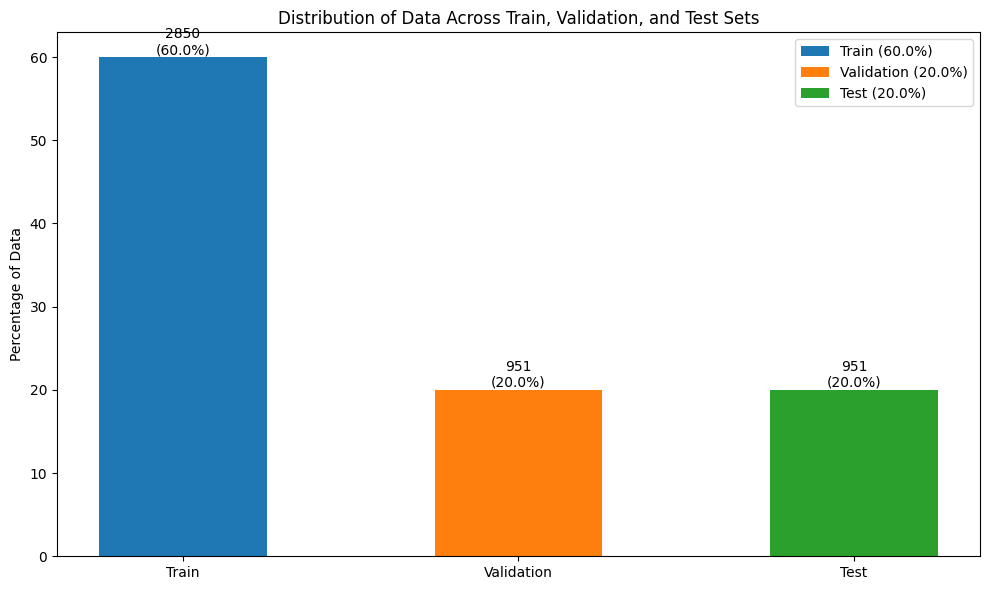

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np

train_ratio = 0.60
val_ratio = 0.20
test_ratio = 0.20

df_train_val, df_test = train_test_split(df, test_size=test_ratio, stratify=df['Class'], random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=val_ratio/(train_ratio+val_ratio), stratify=df_train_val['Class'], random_state=42)

# Prepare data for visualization
datasets = [df_train, df_val, df_test]
names = ['Train', 'Validation', 'Test']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(names))
total = len(df)
widths = [len(d) / total for d in datasets]

for i, (dataset, name, color) in enumerate(zip(datasets, names, colors)):
    count = len(dataset)
    percentage = count / total * 100
    ax.bar(i, percentage, width=0.5, color=color, label=f'{name} ({percentage:.1f}%)')
    ax.text(i, percentage, f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')

ax.set_ylabel('Percentage of Data')
ax.set_title('Distribution of Data Across Train, Validation, and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()

plt.tight_layout()
plt.show()

#new

#new beca

In [16]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [17]:
# Define image size and batch size
width = 256
height = 256
image_size = (width, height)

Rescale normalise

In [18]:
# Define generator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,

)

# Define generator for validation and testing (only rescaling, no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col="Image_Path",
    y_col="Class",
    target_size=image_size,
    batch_size=32,
    # color_mode="rgb",
    class_mode="sparse",
    shuffle=False
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col="Image_Path",
    y_col="Class",
    target_size=image_size,
    batch_size=32,
    # color_mode="rgb",
    class_mode="sparse",
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col="Image_Path",
    y_col="Class",
    target_size=image_size,
    batch_size=32,
    # color_mode="rgb",
    class_mode="sparse",
    shuffle=False
)

Found 2850 validated image filenames belonging to 9 classes.
Found 951 validated image filenames belonging to 9 classes.
Found 951 validated image filenames belonging to 9 classes.


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU, Softmax

# Set random seed for reproducibility
seed = 42
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

cnn_model2 = Sequential()

cnn_model2.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(256, 256, 3)))
cnn_model2.add(BatchNormalization())  # Added Batch Normalization
cnn_model2.add(ReLU())  # ReLU activation
cnn_model2.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
cnn_model2.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
cnn_model2.add(BatchNormalization())  # Added Batch Normalization
cnn_model2.add(ReLU())  # ReLU activation
cnn_model2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
cnn_model2.add(Flatten())

# Fully connected layer with dropout
cnn_model2.add(Dense(units=128, activation='relu'))
cnn_model2.add(Dense(units=64, activation='relu'))

# Output layer for classification
cnn_model2.add(Dense(units=9, activation='softmax'))  # 9 classes

cnn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',  # Sparse as classes are integers
                  metrics=['accuracy'])

cnn_model2.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      33,554,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,583,177 (128.11 MB)

 Trainable params: 33,582,985 (128.11 MB)

 Non-trainable params: 192 (768.00 B)

In [18]:
# Train the model
history_cnn_model2 = cnn_model2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,

)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 757s 8s/step - accuracy: 0.2311 - loss: 36.4384 - val_accuracy: 0.1083 - val_loss: 11.2704
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 774s 8s/step - accuracy: 0.3829 - loss: 7.2422 - val_accuracy: 0.1525 - val_loss: 6.4648
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 722s 8s/step - accuracy: 0.5363 - loss: 2.0778 - val_accuracy: 0.3260 - val_loss: 4.0768
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 744s 8s/step - accuracy: 0.6008 - loss: 1.7355 - val_accuracy: 0.3449 - val_loss: 3.8256
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 765s 8s/step - accuracy: 0.6225 - loss: 1.5730 - val_accuracy: 0.3859 - val_loss: 3.4545
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 760s 8s/step - accuracy: 0.6924 - loss: 1.1578 - val_accuracy: 0.5142 - val_loss: 2.2098
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 725s 8s/step - accuracy: 0.7431 - loss: 0.8104 - val_accuracy: 0.5216 - val_loss: 2.4467
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 746s 8s/step - accuracy: 0.6955 - loss: 1.2688 - val_accuracy: 0.4858 - val_loss: 

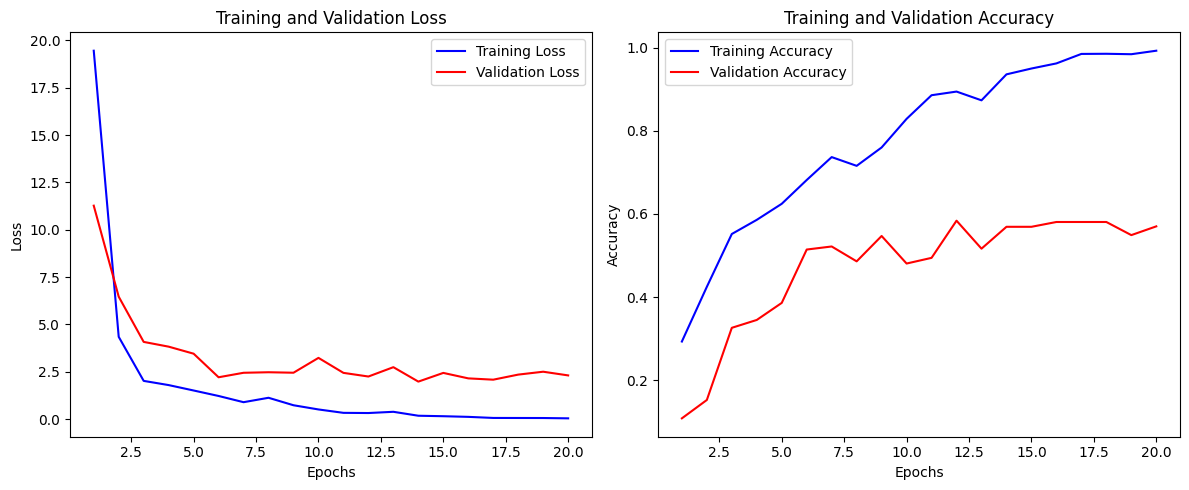

In [19]:
import matplotlib.pyplot as plt

# Extract the metrics from the history object
history_dict = history_cnn_model2.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model2.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6165 - loss: 1.9642
Test Loss: 1.9897
Test Accuracy: 0.6183


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_prob = cnn_model2.predict(test_generator)

y_pred_class = np.argmax(y_pred_prob, axis=-1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred_class, target_names=class_names))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_class))

30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step
Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.52      0.75      0.62        92
      Food Organics       0.73      0.67      0.70        82
              Glass       0.66      0.70      0.68        84
              Metal       0.59      0.63      0.61       158
Miscellaneous Trash       0.43      0.37      0.40        99
              Paper       0.70      0.63      0.66       100
            Plastic       0.58      0.66      0.62       185
      Textile Trash       0.72      0.20      0.32        64
         Vegetation       0.88      0.79      0.84        87

           accuracy                           0.62       951
          macro avg       0.65      0.60      0.60       951
       weighted avg       0.63      0.62      0.61       951


Confusion Matrix:
[[ 69   1   5   4   1   6   6   0   0]
 [  7  55   1   3   5   0   4   0   7]
 [  8   0  59   6   1   1   9   0   0]
 [  6 

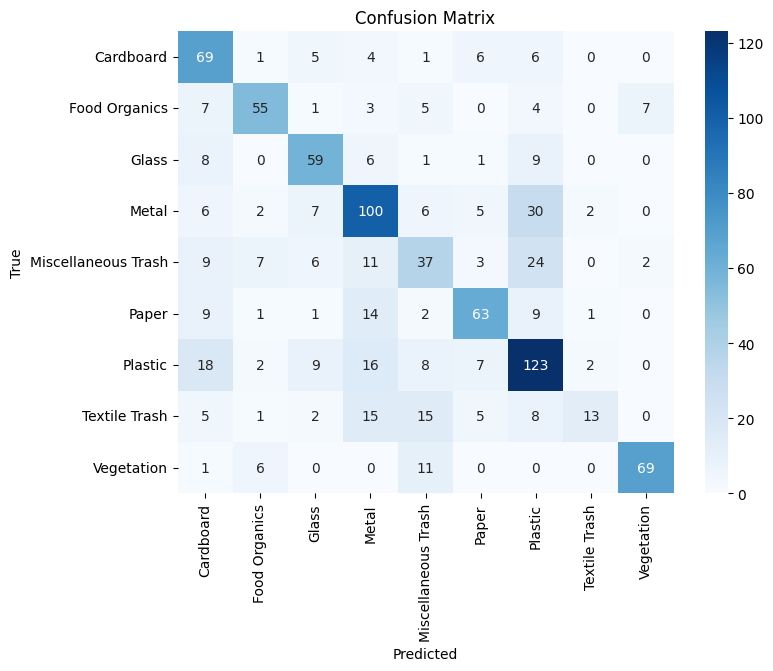

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [22]:
# Save the entire model, including architecture, optimizer, and weights
cnn_model2.save('cnn_model2.h5')


In [23]:
# Save the model weights
cnn_model2.save_weights('cnn_model2.weights.h5')


In [ ]:
# Load the training history
with open('training_history.json', 'r') as f:
    history_dict = json.load(f)

loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']



Training with learning rate: 0.0001
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 623s 7s/step - accuracy: 0.2898 - loss: 4.7540 - val_accuracy: 0.1746 - val_loss: 2.1619
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 614s 7s/step - accuracy: 0.5600 - loss: 1.3100 - val_accuracy: 0.1483 - val_loss: 2.7955
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 616s 7s/step - accuracy: 0.6813 - loss: 0.9135 - val_accuracy: 0.1788 - val_loss: 3.5116
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 624s 7s/step - accuracy: 0.7766 - loss: 0.7013 - val_accuracy: 0.2744 - val_loss: 2.3635
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 619s 7s/step - accuracy: 0.8282 - loss: 0.5349 - val_accuracy: 0.3764 - val_loss: 2.0526

Training with learning rate: 0.001
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 610s 7s/step - accuracy: 0.2718 - loss: 39.2278 - val_accuracy: 0.1146 - val_loss: 12.1418
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 599s 7s/step - accuracy: 0.4320 - loss: 9.3167 - val_accuracy: 0.1840 - val_loss: 21.6863
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 621s 

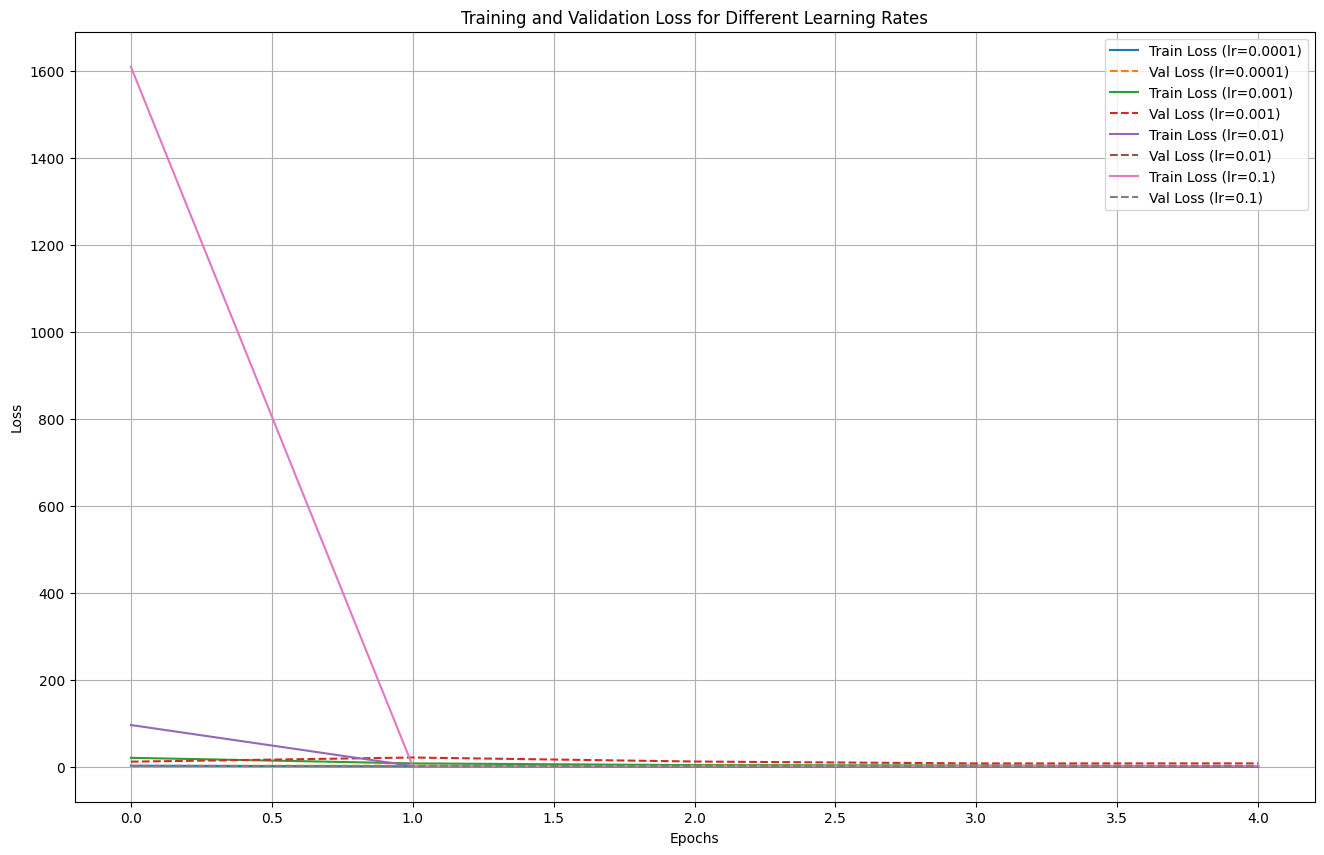

In [41]:
import matplotlib.pyplot as plt
import tensorflow as tf

learning_rates = [0.0001, 0.001, 0.01, 0.1]

histories = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    # Create a new instance of the model
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(256, 256, 3)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=9, activation='softmax')
    ])

    # Compile the model with the current learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model and store the history
    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator,
        verbose=1
    )

    # Store the history for this learning rate
    histories[lr] = history.history

# Plot training and validation loss for each learning rate
plt.figure(figsize=(16, 10))

for lr in learning_rates:
    plt.plot(histories[lr]['loss'], label=f'Train Loss (lr={lr})')
    plt.plot(histories[lr]['val_loss'], linestyle='--', label=f'Val Loss (lr={lr})')

plt.title('Training and Validation Loss for Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
